## **Categorical Embedding in Structured Data**

## **Importing the required libraries**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
import tensorflow.keras as keras
import os
from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import pydot_ng as pydot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Column names**

In [ ]:
header = ["age", "workclass", 'fnlwgt', 'education', 'education-num', 'marital-status', 
          'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
          'hours-per-week','native-country','target']

Setting up the path of data

In [ ]:
path = '/content/drive/My Drive/RmseAccuracy/CategoricalEmbedding'

In [ ]:
def load_data(type='train', dataname = 'adult.data'):
  
  '''
  This function load the train data and test data, does basic processing 
  required to load the data
  Input - data type, data name
  Return the pandas dataframe of the required csv file
  '''

  if type =='train':
    data = pd.read_csv(os.path.join(path, dataname), header=None, names = header, na_values=[' ?'])
    data = data.dropna()
    data['target'] = np.where(data['target'].str.strip() == '<=50K', 0, 1)
  else:
    data = pd.read_csv(os.path.join(path, dataname), header=None, names = header, skiprows=1, na_values=[' ?'])
    data = data.dropna()
    data['target'] = np.where(data['target'].str.strip() == '<=50K.', 0, 1)
  return data

train_data = load_data('train', 'adult.data')
test_data = load_data('test', 'adult.test')

In [ ]:
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Checking the categorical columns in the training data

In [ ]:
train_data.select_dtypes(['object']).columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

**Label encoding of all the categorical columns and saving the label encoder as dictionary**

In [ ]:
le_dict= {}
for col in train_data.select_dtypes(['object']):
  le = LabelEncoder()
  train_data[col] = le.fit_transform(train_data[col])
  test_data[col] = le.transform(test_data[col])
  #Save a mapping of categorical columns values and its transforamtion - needed 
  #later on for mapping purposes
  le_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
# Printing the label encoder dictionary
le_dict

{'education': {' 10th': 0,
  ' 11th': 1,
  ' 12th': 2,
  ' 1st-4th': 3,
  ' 5th-6th': 4,
  ' 7th-8th': 5,
  ' 9th': 6,
  ' Assoc-acdm': 7,
  ' Assoc-voc': 8,
  ' Bachelors': 9,
  ' Doctorate': 10,
  ' HS-grad': 11,
  ' Masters': 12,
  ' Preschool': 13,
  ' Prof-school': 14,
  ' Some-college': 15},
 'marital-status': {' Divorced': 0,
  ' Married-AF-spouse': 1,
  ' Married-civ-spouse': 2,
  ' Married-spouse-absent': 3,
  ' Never-married': 4,
  ' Separated': 5,
  ' Widowed': 6},
 'native-country': {' Cambodia': 0,
  ' Canada': 1,
  ' China': 2,
  ' Columbia': 3,
  ' Cuba': 4,
  ' Dominican-Republic': 5,
  ' Ecuador': 6,
  ' El-Salvador': 7,
  ' England': 8,
  ' France': 9,
  ' Germany': 10,
  ' Greece': 11,
  ' Guatemala': 12,
  ' Haiti': 13,
  ' Holand-Netherlands': 14,
  ' Honduras': 15,
  ' Hong': 16,
  ' Hungary': 17,
  ' India': 18,
  ' Iran': 19,
  ' Ireland': 20,
  ' Italy': 21,
  ' Jamaica': 22,
  ' Japan': 23,
  ' Laos': 24,
  ' Mexico': 25,
  ' Nicaragua': 26,
  ' Outlying-US(Gu

In [ ]:
# Viewing the data after label encoding
train_data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


### **Splitting the train data further into training and testing for XGB evaluation**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['target'], axis = 1), train_data['target'], random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22621, 14), (7541, 14), (22621,), (7541,))

Building a vanilla XGB model on the training data

In [ ]:
params = {'n_estimators' : 500,
          'max_depth': 5,
          'min_child_weight' : 50,
          'gamma': 0.01}
xgb_classifier = XGBClassifier(**params)
xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10)

[0]	validation_0-error:0.152897
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.148256
[2]	validation_0-error:0.147991
[3]	validation_0-error:0.148124
[4]	validation_0-error:0.150245
[5]	validation_0-error:0.149052
[6]	validation_0-error:0.148389
[7]	validation_0-error:0.149582
[8]	validation_0-error:0.1464
[9]	validation_0-error:0.147461
[10]	validation_0-error:0.147858
[11]	validation_0-error:0.147593
[12]	validation_0-error:0.147593
[13]	validation_0-error:0.146798
[14]	validation_0-error:0.146665
[15]	validation_0-error:0.145471
[16]	validation_0-error:0.145074
[17]	validation_0-error:0.144278
[18]	validation_0-error:0.144411
[19]	validation_0-error:0.144676
[20]	validation_0-error:0.144808
[21]	validation_0-error:0.144411
[22]	validation_0-error:0.144543
[23]	validation_0-error:0.14388
[24]	validation_0-error:0.144145
[25]	validation_0-error:0.144013
[26]	validation_0-error:0.143615
[27]	validation_0-error:0.14388
[28]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Making predictions on the test data using XGB model

In [ ]:
xgb_classifier.predict_proba(test_data.drop(['target'], axis = 1))[:,1]

array([0.00637804, 0.2809648 , 0.2034492 , ..., 0.735052  , 0.40594822,
       0.74551255], dtype=float32)

Checking the AUC of the ROC curve to evaluate the model

In [ ]:
roc_auc_score(test_data['target'], xgb_classifier.predict_proba(test_data.drop(['target'], axis = 1))[:,1])

0.912648446421774

## **Focus on the categorical embeddings**

In [ ]:
# We need to do categorical embedding for workclass and occupation variables

In [ ]:
# check how many unique values are present for occupation and workclass
train_data.occupation.nunique(), train_data.workclass.nunique()

(14, 7)


*   For categorical embedding training, we need to convert the inputs as list to be fed to neural network

*  Appending Occupation and Workclass label encoded values into the list

*   Using the previous XGB X_train and X_test dataset








In [ ]:
categorical_columns = ['occupation','workclass']
input_train_list = []
input_test_list = []
for c in categorical_columns:
  input_train_list.append(X_train[c].values)
  input_test_list.append(X_test[c].values)


In [ ]:
input_train_list


[array([11, 11,  5, ...,  2,  7, 11]), array([2, 2, 2, ..., 2, 4, 3])]

In [ ]:
# input models will capture all the input list
input_models=[]
# output embeddings will capture all the output embeddings
output_embeddings=[]
for c in categorical_columns:
  cat_emb_name= c+'_Embedding'
  #Identifying the number of unique values in the category
  no_of_unique_cat  = X_train[c].nunique()
  # Defining the output embedding size - currently taken it to be 10 for 
  # simplicity, Jeremy Howard Fast AI course gives empirical formula for this to
  # be int(min(np.ceil(no_of_unique_cat/2, 50))) i.e choosing the minimum of
  # 50 or half the number of categories in the column
  embedding_size = 10
  input_model = Input(shape=(1,),name = c+'_Input')
  output_model = Embedding(no_of_unique_cat, embedding_size,name=cat_emb_name)(input_model)
  output_model = Reshape(target_shape=(embedding_size,))(output_model)   

  input_models.append(input_model)
  output_embeddings.append(output_model) 

output = Concatenate()(output_embeddings)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(256, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=['accuracy'])

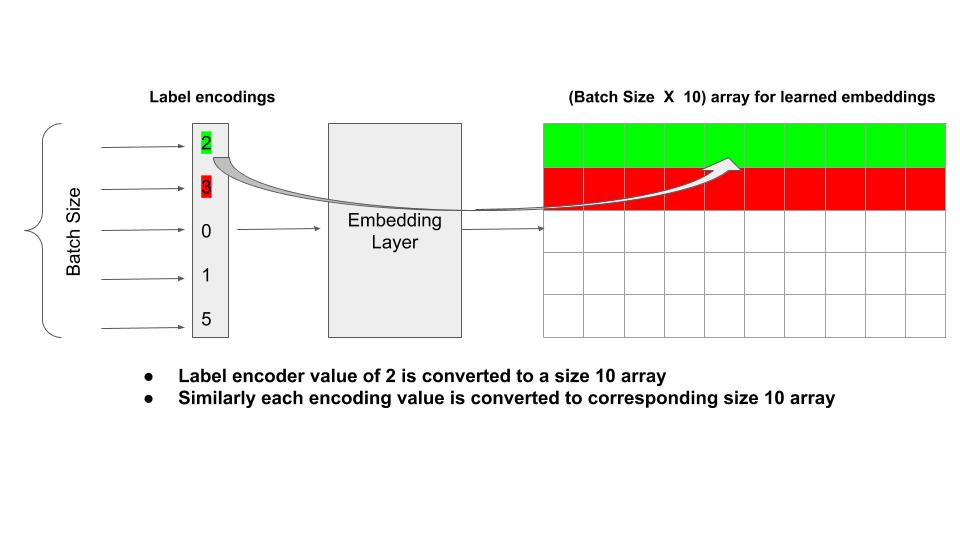

In [ ]:
Image(retina=True, filename = '/content/drive/My Drive/RmseAccuracy/CategoricalEmbedding/Categorical Embedding.jpg')

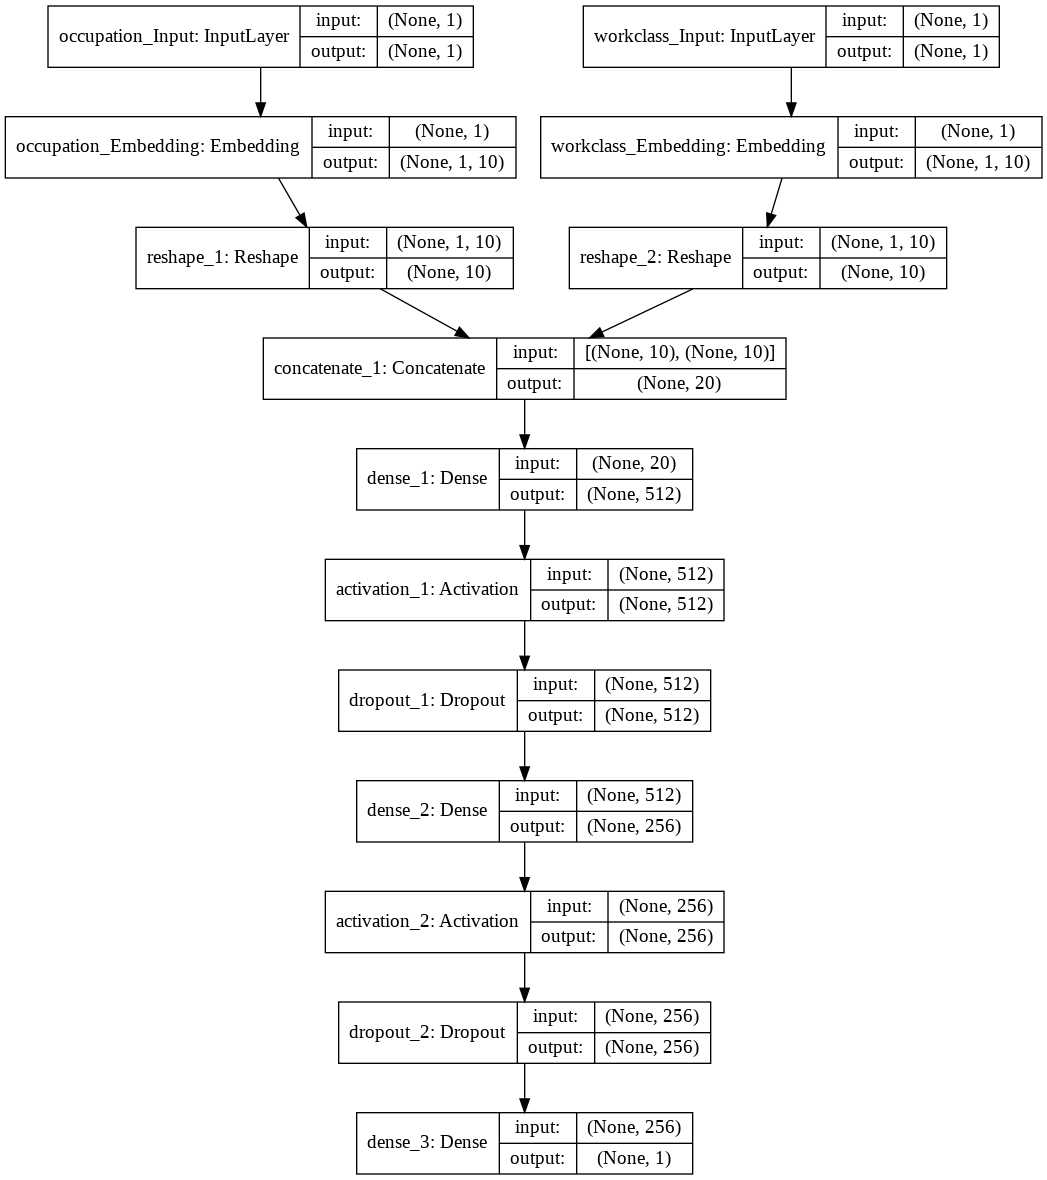

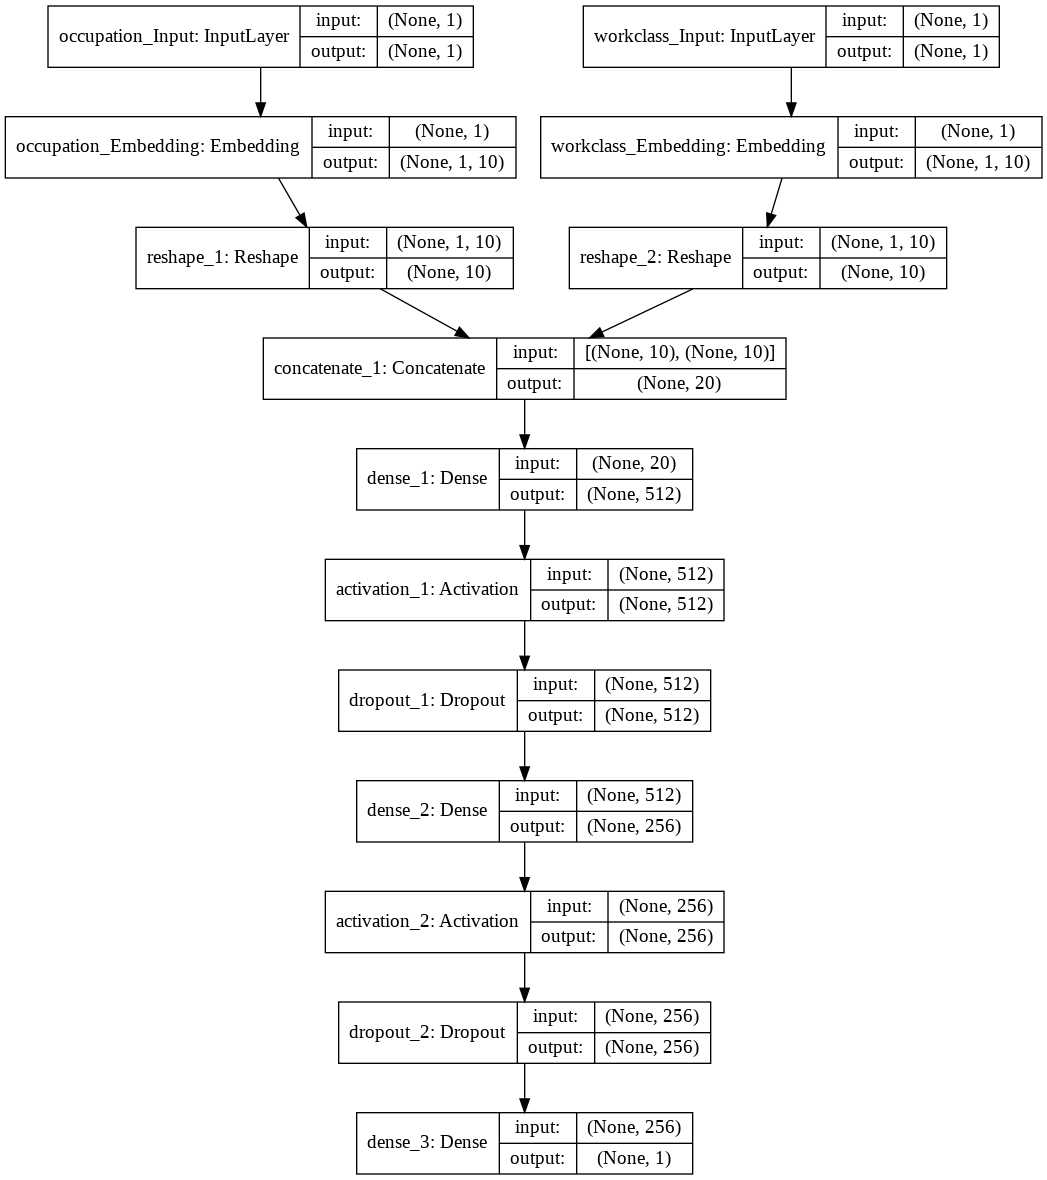

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [ ]:
history  =  model.fit(input_train_list, y_train, validation_data=(input_test_list, y_test) , epochs =  10 , batch_size = 32, verbose= 2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22621 samples, validate on 7541 samples
Epoch 1/10
 - 3s - loss: 0.5026 - accuracy: 0.7548 - val_loss: 0.4900 - val_accuracy: 0.7540
Epoch 2/10
 - 3s - loss: 0.4956 - accuracy: 0.7587 - val_loss: 0.4903 - val_accuracy: 0.7548
Epoch 3/10
 - 3s - loss: 0.4944 - accuracy: 0.7583 - val_loss: 0.4970 - val_accuracy: 0.7548
Epoch 4/10
 - 3s - loss: 0.4942 - accuracy: 0.7601 - val_loss: 0.4905 - val_accuracy: 0.7547
Epoch 5/10
 - 3s - loss: 0.4944 - accuracy: 0.7593 - val_loss: 0.4878 - val_accuracy: 0.7548
Epoch 6/10
 - 3s - loss: 0.4933 - accuracy: 0.7593 - val_loss: 0.4891 - val_accuracy: 0.7548
Epoch 7/10
 - 3s - loss: 0.4930 - accuracy: 0.7594 - val_loss: 0.4892 - val_accuracy: 0.7548
Epoch 8/10
 - 3s - loss: 0.4926 - accuracy: 0.7596 - val_loss: 0.4884 - val_accuracy: 0.7576
Epoch 9/10
 - 3s - loss: 0.4921 - accuracy: 0.7586 - val_loss: 0.4904 - val_accuracy: 0.7588
Epoch 10/10
 - 3s - loss: 0.4931 - accuracy: 0.7582 - val_loss: 0.4903 - val_accuracy: 0.7588


Text(0.5, 1.0, 'loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

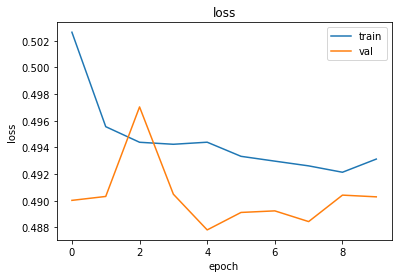

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



*   Extraction of the learned embeddings
*   For embedding layers the weight of the layer is the learned embedding itself
*   We can use get_layer function and then get_weights to extract the wrights




In [ ]:
model.get_layer('workclass_Embedding').get_weights()[0]
# Below are the learned embedding for each unique category in the workclass columns
model.get_layer('workclass_Embedding').get_weights()[0].shape
# The shape is (7,10) meaning 7 unique values each described by 10 values 
# (embedding size)

array([[-0.10944396, -0.03739441,  0.0393861 ,  0.09913016, -0.02676688,
        -0.007929  ,  0.0691274 ,  0.05590609,  0.02192586, -0.14741293],
       [-0.03799545,  0.08222219,  0.09183543, -0.02086814,  0.1323753 ,
        -0.21901013,  0.1818451 , -0.03696182,  0.01556377, -0.04726821],
       [ 0.01629103,  0.01314412, -0.00677302, -0.05358543,  0.01300781,
         0.04054243,  0.03041936, -0.02312245, -0.01209875,  0.06487255],
       [ 0.00176491,  0.03317041,  0.05167554,  0.16565993, -0.15913443,
         0.1309731 , -0.09170835,  0.11787907,  0.13932618, -0.17518333],
       [-0.01450732, -0.02051315, -0.07267959,  0.08701531, -0.03642308,
        -0.181996  , -0.16683532,  0.02473182, -0.04972922,  0.00864047],
       [ 0.07101251,  0.03223592, -0.08936357, -0.0641963 ,  0.03293851,
        -0.07838254, -0.01996578, -0.04260485, -0.07682126,  0.03451914],
       [ 0.4786453 ,  0.038497  , -0.33192754, -0.4768014 ,  0.16279477,
         0.48276958, -0.19107722, -0.35757023

(7, 10)

In [ ]:
model.get_layer('occupation_Embedding').get_weights()[0]
# Below are the learned embedding for each unique category in the occupation columns
model.get_layer('occupation_Embedding').get_weights()[0].shape
# The shape is (14,10) meaning 7 unique values each described by 10 values 
# (embedding size)

array([[ 0.05329772,  0.04524544,  0.02187814, -0.04043812,  0.07431988,
        -0.04234425, -0.06700844, -0.08329464, -0.0869889 ,  0.00812604],
       [ 0.12548222,  0.10617387, -0.08627563, -0.0925864 ,  0.16409631,
        -0.13642839, -0.06483454, -0.13474259, -0.1728838 , -0.14608687],
       [-0.08765166,  0.07392639, -0.03743276,  0.01387029, -0.0775483 ,
         0.05785482,  0.11392703,  0.03213652, -0.03492452, -0.11635946],
       [-0.23592514, -0.10234439,  0.14757782,  0.09616396, -0.23341008,
         0.17148712,  0.11486172,  0.16498114,  0.17651533, -0.00575583],
       [ 0.10744286,  0.09805239, -0.10764217, -0.05756306,  0.02988581,
        -0.09439937,  0.02390567, -0.12327146, -0.06048558, -0.08880399],
       [ 0.11564554,  0.09134598, -0.11275339, -0.09824797,  0.0716814 ,
        -0.10805145, -0.05859192, -0.09385139, -0.06150849,  0.00336984],
       [ 0.04975352,  0.03986579,  0.00799101, -0.05455493,  0.06207762,
        -0.04982155, -0.03843265, -0.05507221

(14, 10)

In [ ]:
# We saved the label encoder for extracting the embeddings
le_dict['occupation'].items()

dict_items([(' Adm-clerical', 0), (' Armed-Forces', 1), (' Craft-repair', 2), (' Exec-managerial', 3), (' Farming-fishing', 4), (' Handlers-cleaners', 5), (' Machine-op-inspct', 6), (' Other-service', 7), (' Priv-house-serv', 8), (' Prof-specialty', 9), (' Protective-serv', 10), (' Sales', 11), (' Tech-support', 12), (' Transport-moving', 13)])

# **Mapping of the embedding to the actual categories**

In [ ]:
# Need to extract embedding based on the label encoding
occupation_embeddings = {idx:model.get_layer('occupation_Embedding').get_weights()[0][idx] for w, idx in le_dict['occupation'].items()}
workclass_embeddings = {idx:model.get_layer('workclass_Embedding').get_weights()[0][idx] for w, idx in le_dict['workclass'].items()}


Converting the arrays to DF to be merged with main dataset

In [ ]:
occupation_embeddings_df = pd.DataFrame(occupation_embeddings)
workclass_embeddings_df = pd.DataFrame(workclass_embeddings)

In [ ]:
occupation_embeddings_df = occupation_embeddings_df.T.reset_index()
occupation_embeddings_df

,index,0,1,2,3,4,5,6,7,8,9
0,0,0.053298,0.045245,0.021878,-0.040438,0.074320,-0.042344,-0.067008,-0.083295,-0.086989,0.008126
1,1,0.125482,0.106174,-0.086276,-0.092586,0.164096,-0.136428,-0.064835,-0.134743,-0.172884,-0.146087
2,2,-0.087652,0.073926,-0.037433,0.013870,-0.077548,0.057855,0.113927,0.032137,-0.034925,-0.116359
3,3,-0.235925,-0.102344,0.147578,0.096164,-0.233410,0.171487,0.114862,0.164981,0.176515,-0.005756
4,4,0.107443,0.098052,-0.107642,-0.057563,0.029886,-0.094399,0.023906,-0.123271,-0.060486,-0.088804
5,5,0.115646,0.091346,-0.112753,-0.098248,0.071681,-0.108051,-0.058592,-0.093851,-0.061508,0.003370
6,6,0.049754,0.039866,0.007991,-0.054555,0.062078,-0.049822,-0.038433,-0.055072,-0.033101,0.045560
7,7,0.166118,0.116730,-0.180523,-0.102893,0.093222,-0.113017,-0.004853,-0.162021,-0.061917,-0.062998
8,8,0.532285,0.426485,-0.508796,-0.388056,0.492570,-0.470784,-0.128087,-0.550102,-0.336055,-0.340440
9,9,-0.069134,-0.157620,0.171456,0.160356,-0.040656,0.135299,-0.126087,0.123124,0.049525,0.108499


In [ ]:
workclass_embeddings_df = workclass_embeddings_df.T.reset_index()
workclass_embeddings_df

,index,0,1,2,3,4,5,6,7,8,9
0,0,-0.109444,-0.037394,0.039386,0.099130,-0.026767,-0.007929,0.069127,0.055906,0.021926,-0.147413
1,1,-0.037995,0.082222,0.091835,-0.020868,0.132375,-0.219010,0.181845,-0.036962,0.015564,-0.047268
2,2,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
3,3,0.001765,0.033170,0.051676,0.165660,-0.159134,0.130973,-0.091708,0.117879,0.139326,-0.175183
4,4,-0.014507,-0.020513,-0.072680,0.087015,-0.036423,-0.181996,-0.166835,0.024732,-0.049729,0.008640
5,5,0.071013,0.032236,-0.089364,-0.064196,0.032939,-0.078383,-0.019966,-0.042605,-0.076821,0.034519
6,6,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630


TSNE visualization for workclass embeddings

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(workclass_embeddings_df.T)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.562088
[t-SNE] KL divergence after 300 iterations: 0.310926


<Figure size 1152x720 with 0 Axes>

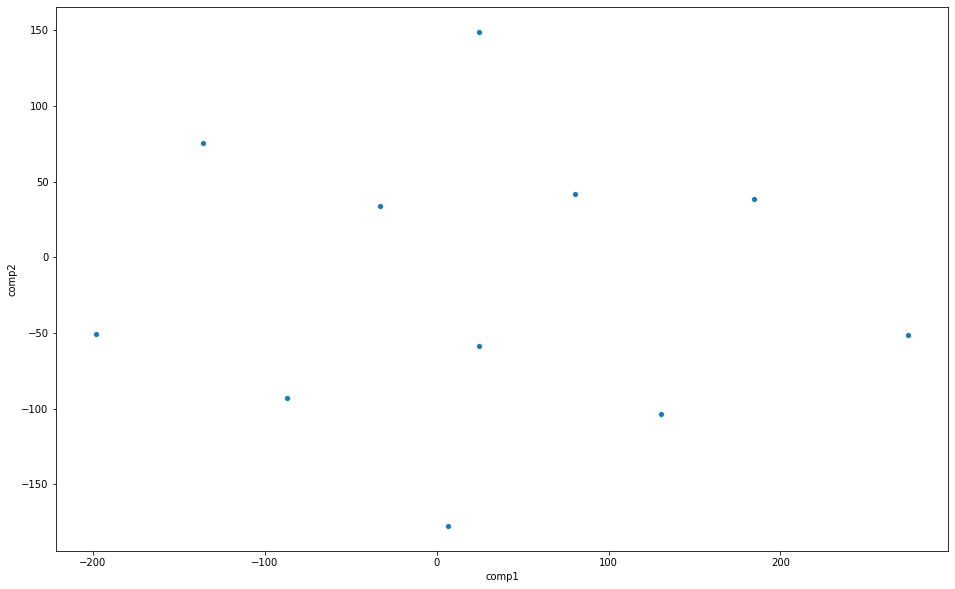

In [ ]:
tsne_df = pd.DataFrame()
tsne_df['comp1'] = tsne_results[:,0]
tsne_df['comp2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="comp1", y="comp2",
    data=tsne_df,
    legend="full",
    alpha=1
)

*   Since we want to evaluate on the performance on the same data set as XGB
*   Combining the XGB dataset together to replace workclass column with embedding



In [ ]:
# Dataset used for training XGB model
df_train_CE = pd.concat([X_train, y_train], axis = 1)
# Dataset used for testing XGB model
df_test_CE = pd.concat([X_test, y_test], axis = 1)

In [ ]:
# This is the hold out sample for final ROC calculation
test_data_CE = test_data

Merging the embedding into structured data for training data

In [ ]:
X_train_CE = pd.merge(df_train_CE, workclass_embeddings_df, how = 'inner', left_on='workclass', right_on='index')
y_train = X_train_CE['target']
X_train_CE.drop(['workclass', 'index', 'target'], axis=1, inplace=True)
X_train_CE

,age,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,0,1,2,3,4,5,6,7,8,9
0,28,92262,9,13,2,11,0,4,1,0,0,40,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
1,49,281647,9,13,2,11,0,4,1,0,0,45,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
2,39,231491,11,9,4,5,2,4,1,0,0,40,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
3,36,183902,9,13,2,9,5,4,0,0,0,4,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
4,27,153078,14,15,4,9,3,1,1,0,0,40,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22616,68,174695,15,10,3,4,4,4,0,0,0,25,38,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
22617,46,142210,11,9,2,6,5,4,0,0,0,25,38,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
22618,62,170114,7,12,2,4,0,4,1,0,0,50,38,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
22619,21,232719,11,9,4,2,3,2,1,0,0,40,38,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630


In [ ]:
X_test_CE = pd.merge(df_test_CE, workclass_embeddings_df, how = 'inner', left_on='workclass', right_on='index')
y_test = X_test_CE['target']
X_test_CE.drop(['workclass', 'index', 'target'], axis=1, inplace=True)
X_test_CE

,age,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,0,1,2,3,4,5,6,7,8,9
0,28,76714,14,15,4,9,1,4,1,0,0,55,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
1,41,178431,11,9,2,2,0,1,1,0,0,40,35,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
2,53,290640,11,9,2,7,0,4,1,0,0,50,10,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
3,31,215297,11,9,2,2,0,4,1,0,0,45,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
4,34,94413,11,9,2,13,0,4,1,0,0,40,38,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7536,29,31161,11,9,0,3,1,3,0,0,0,40,38,-0.109444,-0.037394,0.039386,0.099130,-0.026767,-0.007929,0.069127,0.055906,0.021926,-0.147413
7537,30,321990,15,10,2,0,0,4,1,7298,0,48,4,-0.109444,-0.037394,0.039386,0.099130,-0.026767,-0.007929,0.069127,0.055906,0.021926,-0.147413
7538,72,121004,11,9,2,7,0,4,1,0,0,55,38,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
7539,52,198262,11,9,2,0,5,4,0,0,0,30,38,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630


In [ ]:
test_data_CE = pd.merge(test_data_CE, workclass_embeddings_df, how = 'inner', left_on='workclass', right_on='index')
test_data_CE.drop(['workclass', 'index'], axis=1, inplace=True)
test_data_CE

,age,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,0,1,2,3,4,5,6,7,8,9
0,25,226802,1,7,4,6,3,2,1,0,0,40,38,0,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
1,38,89814,11,9,2,4,0,4,1,0,0,50,38,0,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
2,44,160323,15,10,2,6,0,2,1,7688,0,40,38,1,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
3,34,198693,0,6,4,7,1,4,1,0,0,30,38,0,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
4,24,369667,15,10,4,7,4,4,0,0,0,40,38,0,0.016291,0.013144,-0.006773,-0.053585,0.013008,0.040542,0.030419,-0.023122,-0.012099,0.064873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,51,124963,7,12,2,11,0,4,1,0,0,45,38,0,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
15056,64,209291,11,9,2,5,0,4,1,0,0,60,38,1,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
15057,50,123004,11,9,2,6,3,4,0,0,1887,40,38,1,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630
15058,39,334291,11,9,2,3,0,4,1,0,0,40,38,0,0.478645,0.038497,-0.331928,-0.476801,0.162795,0.482770,-0.191077,-0.357570,-0.293583,0.522630


Using the exact same XGB model used before as well again

In [ ]:
params = {'n_estimators' : 500,
          'max_depth': 5,
          'min_child_weight' : 50,
          'gamma': 0.01}
xgb_classifier = XGBClassifier(**params)
xgb_classifier.fit(X_train_CE, y_train, eval_set=[(X_test_CE, y_test)], early_stopping_rounds=10)

[0]	validation_0-error:0.152897
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.148256
[2]	validation_0-error:0.147991
[3]	validation_0-error:0.148124
[4]	validation_0-error:0.150245
[5]	validation_0-error:0.149052
[6]	validation_0-error:0.148389
[7]	validation_0-error:0.149582
[8]	validation_0-error:0.146532
[9]	validation_0-error:0.147328
[10]	validation_0-error:0.147195
[11]	validation_0-error:0.147461
[12]	validation_0-error:0.147461
[13]	validation_0-error:0.147195
[14]	validation_0-error:0.146798
[15]	validation_0-error:0.145471
[16]	validation_0-error:0.145737
[17]	validation_0-error:0.144941
[18]	validation_0-error:0.144411
[19]	validation_0-error:0.144145
[20]	validation_0-error:0.144278
[21]	validation_0-error:0.144145
[22]	validation_0-error:0.144013
[23]	validation_0-error:0.144278
[24]	validation_0-error:0.14388
[25]	validation_0-error:0.143482
[26]	validation_0-error:0.143482
[27]	validation_0-error:0.142024
[28]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_classifier.predict_proba(test_data_CE.drop(['target'], axis = 1))[:,1]

array([0.00307775, 0.2284234 , 0.95796543, ..., 0.24628557, 0.36356145,
       0.00368421], dtype=float32)

In [ ]:
roc_auc_score(test_data_CE['target'], xgb_classifier.predict_proba(test_data_CE.drop(['target'], axis = 1))[:,1])

0.9149106395127521

# The performance of new model is slightly better than the old model

References:


*   https://towardsdatascience.com/categorical-embedding-and-transfer-learning-dd3c4af6345d
*   https://towardsdatascience.com/understanding-entity-embeddings-and-its-application-69e37ae1501d
*   https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
*   https://medium.com/@apiltamang/learning-entity-embeddings-in-one-breath-b35da807b596





